<a href="https://colab.research.google.com/github/NotAbdelrahmanelsayed/sentiment_crypto_forcasting/blob/main/Modeling_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NotAbdelrahmanelsayed/sentiment_crypto_forcasting.git
%mv  /content/sentiment_crypto_forcasting/data  /content/data
%mv  /content/sentiment_crypto_forcasting/modeling.py  /content/modeling.py
%mv  /content/sentiment_crypto_forcasting/figures.py  /content/figures.py
%mv  /content/sentiment_crypto_forcasting/report.py  /content/report.py

Cloning into 'sentiment_crypto_forcasting'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 59 (delta 25), reused 46 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 471.94 KiB | 16.85 MiB/s, done.
Resolving deltas: 100% (25/25), done.


#####Import Dependencies


In [2]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.9 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages


In [4]:
config = {
    "sentiment_data_path": "/content/data/sentiments_2025.csv",
    "coins_data_directory": "/content/data/coins_data",
}
directory = config['coins_data_directory']
csv_files_list = []

for file_name in os.listdir(directory):
  if file_name.endswith('.csv'):
    file_path = os.path.join(directory, file_name)
    csv_files_list.append(file_path)


In [5]:
categories = {
    "Fiat Collateralized": ['USDT_usd_history', 'USDC_usd_history'],
    "Crypto-Collateralized": ['DAI_usd_history'],
    "Algorithmic Stablecoins": ['AMPL_usd_history'],
    "Commodity-backed stablecoins": ['PAXG_usd_history'],
    "Bitcoin and ETH": ['BTC_usd_history', 'ETH_usd_history']
}


def define_categories_path(folder_path):
  """Function to define a path for each coins category to save the analysis's pdf"""
  os.makedirs(folder_path, exist_ok=True)
  paths = []
  for category in categories:
    coin_path = os.path.join(folder_path, category + '.pdf')
    paths.append(coin_path)
  return paths

path = '/content/drive/MyDrive/news_impact/2025-3/results/'
pdfs_paths = define_categories_path(path)
config['pdfs_paths'] = {category: pdfs_paths[i] for i, category in enumerate(categories)}

In [6]:
def read_coin_data(coin_folder):
    coin_data = []
    for file in os.listdir(coin_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(coin_folder, file)
            df = pd.read_csv(file_path)
            df['Symbol'] = file.split('.')[0]
            coin_data.append(df)
    return pd.concat(coin_data, ignore_index=True)
coin_data = read_coin_data(directory)

In [7]:
sentiment_data = pd.read_csv(config['sentiment_data_path'])

In [24]:
def prepare_data(coin_df, sentiment_df):
    coin_df = coin_df.copy()
    sentiment_df = sentiment_df.copy()

    # Ensure 'date' column is in datetime format
    coin_df['date'] = pd.to_datetime(coin_df['date'])
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    # Merge the dataframes on 'date'
    merged_df = pd.merge(coin_df, sentiment_df, on='date', how='inner').copy()
    # merged_df.sort_values('date', inplace=True) # Sort by date

    # Generate target variable (shift close price by -1 day)
    merged_df['target'] = merged_df['CLOSE'].shift(-1)
    shifted_volume = merged_df['VOLUME'].shift(-1)

    # Multi-class target classification
    merged_df["target_class"] = 0  # Default: Minor Change
    merged_df.loc[shifted_volume >= merged_df["VOLUME"] * 1.10, "target_class"] = 2  # High Increase
    merged_df.loc[shifted_volume <= merged_df["VOLUME"] * 0.90, "target_class"] = 1  # High Decrease

    # Drop NaN values (especially from shift operation)
    return merged_df.dropna()


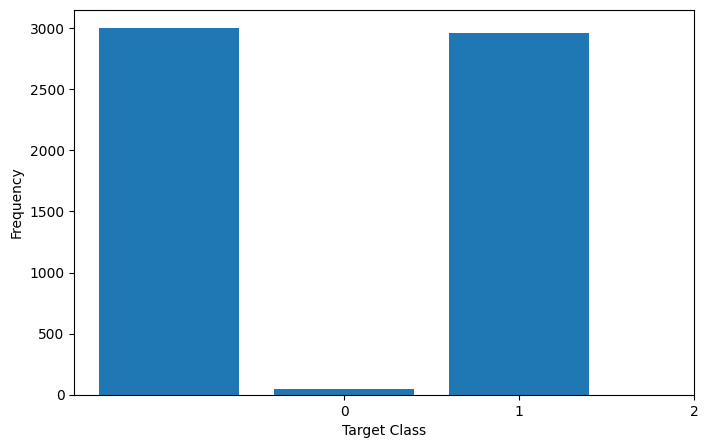

In [22]:
# Get the counts of each class
class_counts = prepare_data(coin_data, sentiment_data)["target_class"].value_counts()

# Plot as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Target Class")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2])
plt.show()


### Regression Model and Helper Functions


In [10]:
def train_regression_model(X_train, y_train):
    model = XGBRegressor(objective='reg:squarederror',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        gpu_id=0
)
    model.fit(X_train, y_train)
    return model

In [11]:
def tune_regression_model(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(
        XGBRegressor(objective='reg:squarederror'),
        param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_


In [12]:
def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2


### Classification Model and Helper Functions


In [13]:
from modeling import (train_classification_model,
                      evaluate_classification_model,
                      tune_classification_model,
                      train_regression_model,
                      tune_regression_model,
                      evaluate_regression_model,

                      )
from figures import (visualize_classification_model,
                     save_fig_as_image,
                     visualize_feature_importance,
                     visualize_regression_model)

###Additional visualizations

#### AI GENERATED CODE: FOR REPORT GENERATION

In [14]:
from report import (create_metrics_figure,
                    create_metrics_table,
                    add_elements_to_pdf)

##Run and Save Analysis Results


In [15]:
def analyze_coin(coin_data, sentiment_data, coin_name, pdfpages, results_df):
    merged_df = prepare_data(coin_data, sentiment_data)
    X = merged_df.drop(columns=['Symbol', 'date', 'CLOSE', 'target', 'target_class', 'HIGH', 'LOW'])
    feature_names = X.columns
    y_reg = merged_df['target']
    y_class = merged_df['target_class']

    split_idx = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
    y_train_class, y_test_class = y_class.iloc[:split_idx], y_class.iloc[split_idx:]

    # Regression task
    # Regression task with tuning
    regression_model, reg_params = tune_regression_model(X_train, y_train_reg)
    mse, rmse, r2 = evaluate_regression_model(regression_model, X_test, y_test_reg)
    regression_metrics = {'MSE': mse, 'RMSE': rmse, 'R^2': r2}

    print(f"\nRegression Model Performance for {coin_name}: MSE = {mse}, RMSE = {rmse}, R^2 = {r2}")

    # Classification task
    classification_model, clf_params = tune_classification_model(X_train, y_train_class)
    accuracy, precision, recall, f1 = evaluate_classification_model(classification_model, X_test, y_test_class)
    classification_metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

    # Saving the results in one DataFrame
    combined_metrics = classification_metrics.copy()
    combined_metrics.update(regression_metrics)
    combined_metrics['coin_name'] = coin_name
    metrics_df = pd.DataFrame([combined_metrics])
    updated_results_df = pd.concat([results_df, metrics_df], ignore_index=True)


    figures = [
        visualize_regression_model(y_test_reg, regression_model.predict(X_test), coin_name),
        visualize_feature_importance(regression_model, feature_names, coin_name),
        visualize_classification_model(classification_model, X_test, y_test_class, coin_name),
        visualize_feature_importance(classification_model, feature_names, coin_name),
        create_metrics_figure(regression_metrics, f'Regression Metrics for {coin_name}'),
        create_metrics_figure(classification_metrics, f'Classification Metrics for {coin_name}', best_params)
    ]

    for fig in figures:
        pdfpages.savefig(fig)
        plt.close(fig)
    return updated_results_df

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:57:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Regression Model Performance for BTC_usd_history: MSE = 8920602.437677694, RMSE = 2986.73775843774, R^2 = 0.6002607289918244


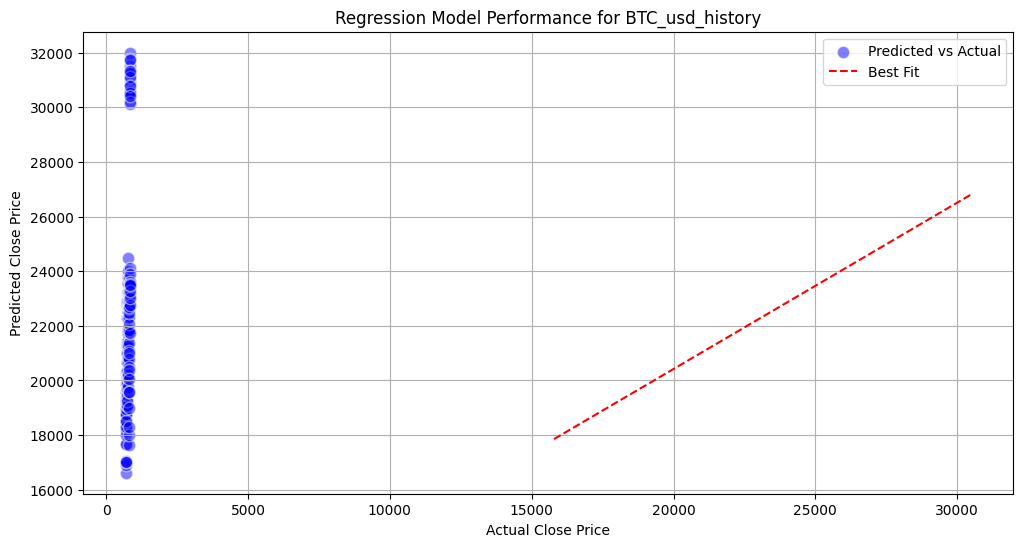

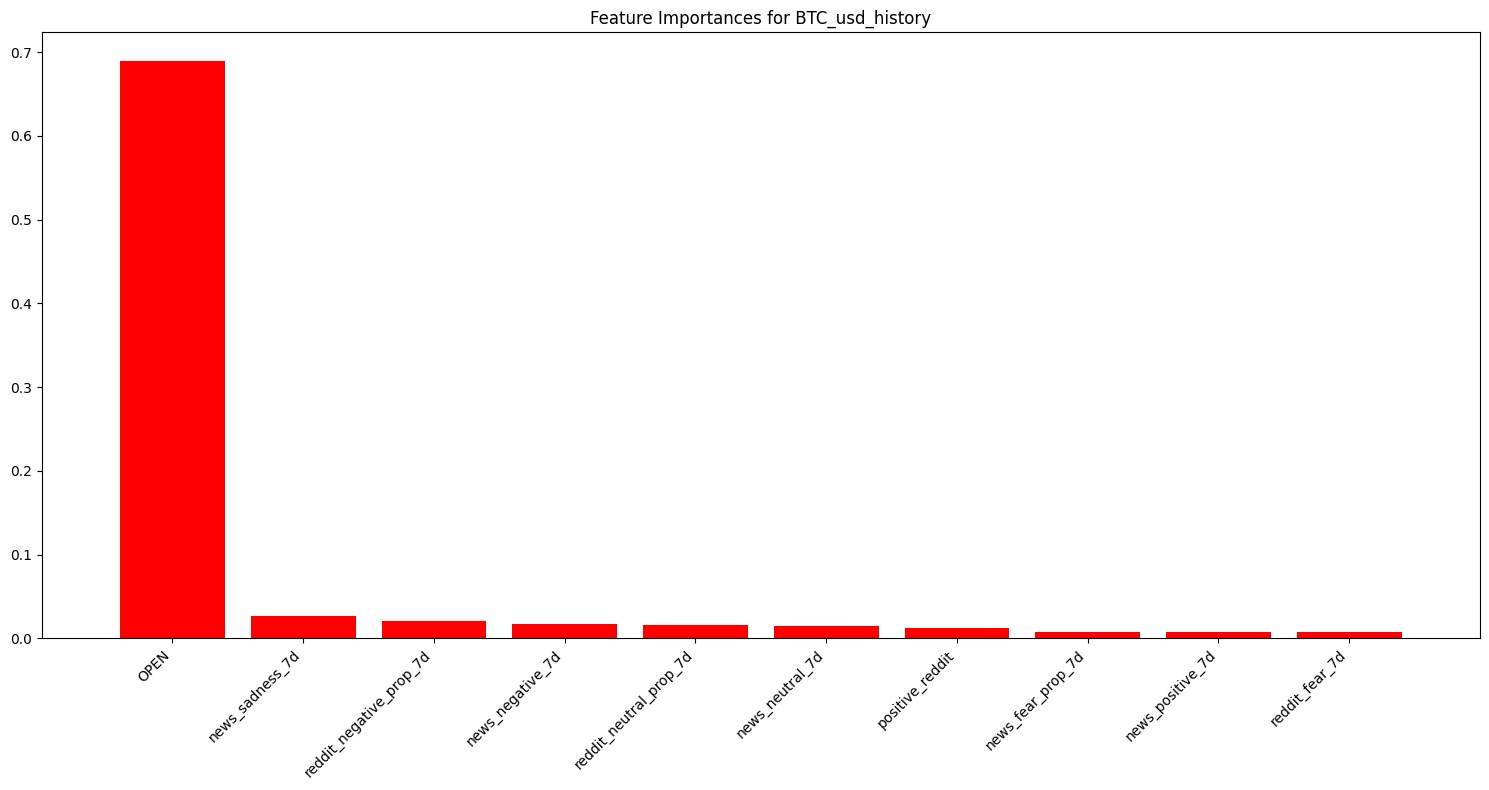

Classification Model Performance for BTC_usd_history:
Accuracy: 0.4651, Precision: 0.6406, Recall: 0.4651, F1-Score: 0.3654


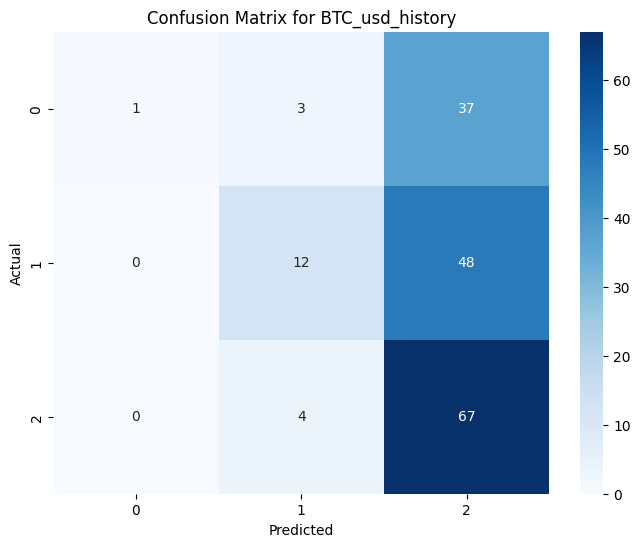

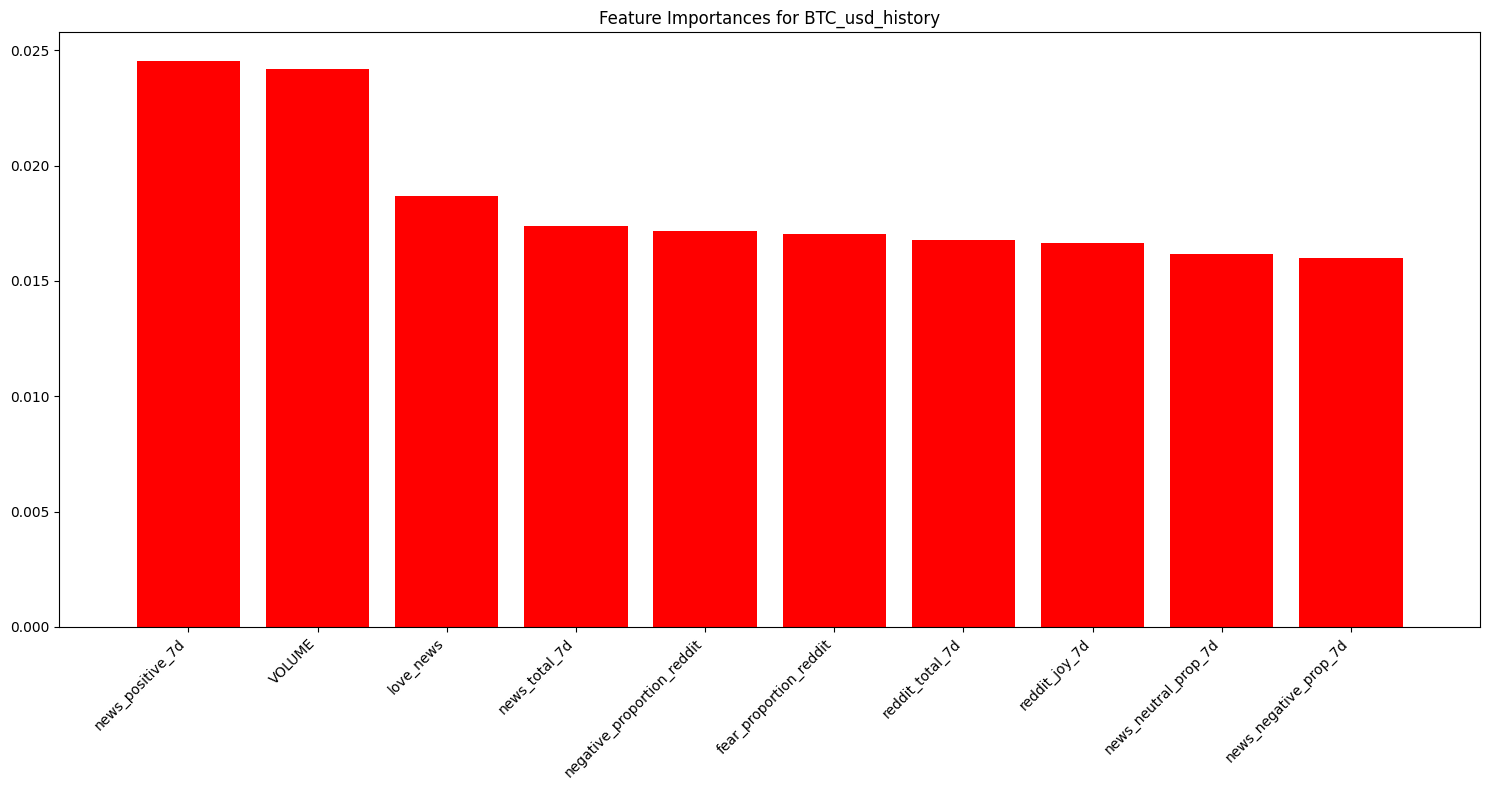

NameError: name 'best_params' is not defined

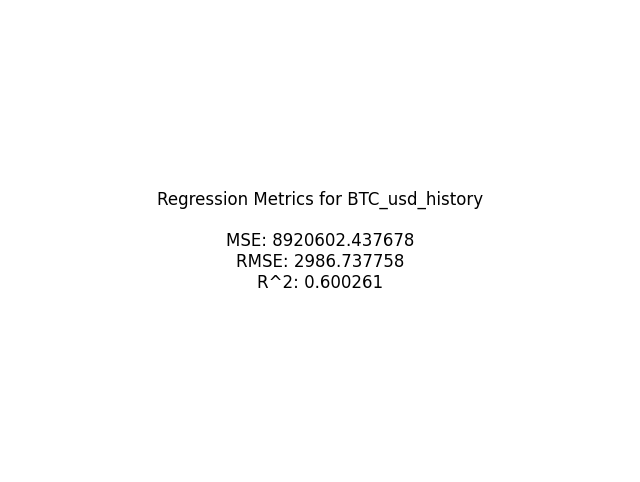

In [16]:
results_df = pd.DataFrame()
pdf_paths = config['pdfs_paths']
for category, pdf_path in pdf_paths.items():
    coin_symbols = categories[category]
    with PdfPages(pdf_path) as pdf_pages:
        for coin_symbol in coin_symbols:
          if coin_symbol == "BTC_usd_history":
            coin_data_filtered = coin_data[coin_data['Symbol'] == coin_symbol]
            results_df = analyze_coin(coin_data_filtered, sentiment_data, coin_symbol, pdf_pages, results_df)

In [ ]:
# results_df.to_csv(os.path.join(path, 'results_df_2024.csv'), index=False)

In [ ]:
# results_df_2024 = results_df
# result_df_older = pd.read_csv(os.path.join(path, 'results_df.csv'))

In [ ]:
# results_df_2024.compare(result_df_older, True, True, result_names=("older", "2024"))

In [ ]:
for coin in coin_data["Symbol"].unique():
  coin_df = coin_data[coin_data["Symbol"] == coin]
  print(f"AVG volume on {coin} {coin_df.Volume.mean()}")